In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import fastparquet
import dask.dataframe as dd
from utils import pipe_newb,pipe_broken,pipe_rental
import koreanize_matplotlib
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import AnovaRM
from scipy.stats import shapiro

c:\Users\chane\AppData\Local\Programs\Python\Python311\Lib\site-packages\dask\dataframe\__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


### 데이터

In [2]:
df_rental = dd.read_parquet('rental.parquet',engine='pyarrow')
df_rental = df_rental.compute()
df_rental = pipe_rental(df_rental)

In [3]:
df_newb = pd.read_csv('Data\원본\신규가입자합산값.csv')
df_newb = pipe_newb(df_newb)

In [4]:
df_broken = pd.read_csv('Data\원본\고장\df_broken.csv')
df_broken = pipe_broken(df_broken)

## 1. 시계열 그래프 추세 시각화 -> 2022년과 2023년 패턴이 다르다는 것을 발견 (평균과 분산 확인) 

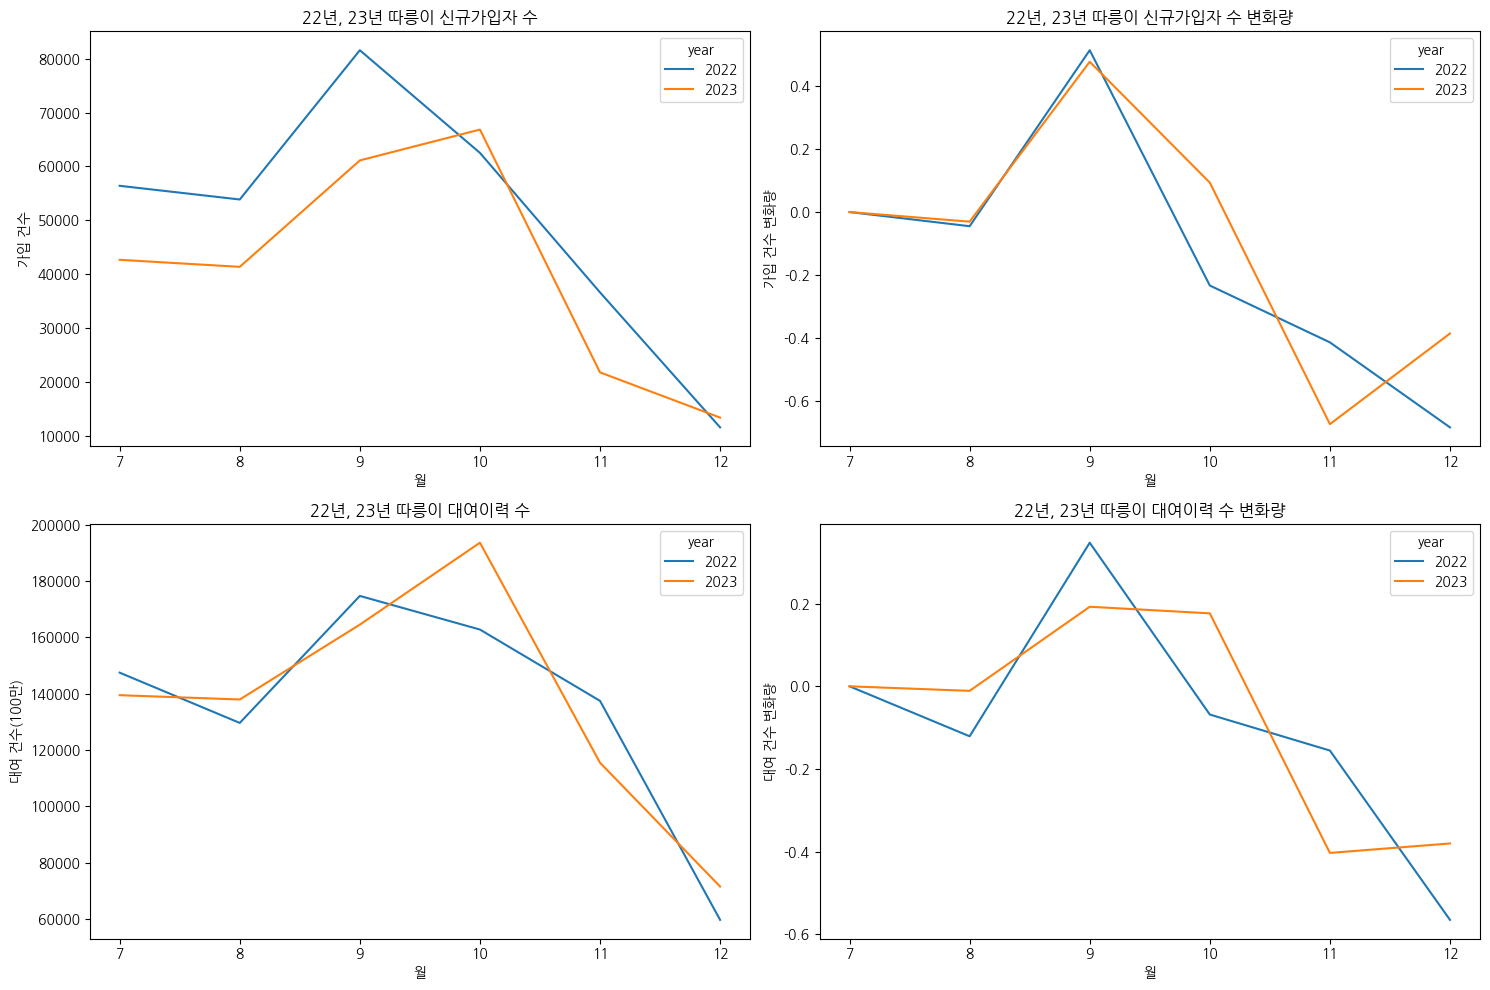

In [5]:
# 신규가입자 건수 groupby
df_newb_groupby = (
    df_newb
    .groupby([df_newb['가입일시'].dt.year.rename('year'), df_newb['가입일시'].dt.month.rename('month')])
    .agg({'가입건수':'sum'})
    .reset_index()    
)
# 신규가입자 건수 2022년도 변화량
df_newb22_groupby = (
    df_newb_groupby
    .loc[df_newb_groupby['year'] == 2022]
    .assign(가입건수_변화량= lambda x: x['가입건수'].pct_change().fillna(0))
) 
# 신규가입자 건수 2023년도 변화량
df_newb23_groupby = (
    df_newb_groupby
    .loc[df_newb_groupby['year'] == 2023]
    .assign(가입건수_변화량= lambda x: x['가입건수'].pct_change().fillna(0))
) 
# 신규가입자 건수 및 변화량 2022년도 2023년도 병합
df_newb_groupby = pd.concat([df_newb22_groupby, df_newb23_groupby])


# 대여이력 건수 groupby
df_rental_groupby = (
    df_rental
    .groupby([df_rental['대여일시'].dt.year.rename('year'), df_rental['대여일시'].dt.month.rename('month')])
    .agg({'자전거번호':'size'})
    .reset_index()
) 
# 대여이력 건수 2022년도 변화량
df_rental22_groupby = (
    df_rental_groupby
    .loc[df_rental_groupby['year'] == 2022]
    .assign(대여건수_변화량= lambda x: x['자전거번호'].pct_change().fillna(0))
) 
# 대여이력 건수 2023년도 변화량
df_rental23_groupby = (
    df_rental_groupby
    .loc[df_rental_groupby['year'] == 2023]
    .assign(대여건수_변화량= lambda x: x['자전거번호'].pct_change().fillna(0))
) 
# 대여이력 건수 및 변화량 2022년도 2023년도 병합
df_rental_groupby = pd.concat([df_rental22_groupby, df_rental23_groupby])

# 신규가입자 정보 및 대여이력정보 시각화
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# 신규가입자 건수 시각화
df_newb_groupby.pivot(index='month', columns='year', values='가입건수').plot(kind='line', ax=axs[0, 0])
axs[0, 0].set_title('22년, 23년 따릉이 신규가입자 수')
axs[0, 0].set_xlabel('월')
axs[0, 0].set_ylabel('가입 건수')

# 신규가입자 변화량 시각화
df_newb_groupby.pivot(index='month', columns='year', values='가입건수_변화량').plot(kind='line', ax=axs[0, 1])
axs[0, 1].set_title('22년, 23년 따릉이 신규가입자 수 변화량')
axs[0, 1].set_xlabel('월')
axs[0, 1].set_ylabel('가입 건수 변화량')

# 대여이력 건수 시각화
df_rental_groupby.pivot(index='month', columns='year', values='자전거번호').plot(kind='line', ax=axs[1, 0])
axs[1, 0].set_title('22년, 23년 따릉이 대여이력 수')
axs[1, 0].set_xlabel('월')
axs[1, 0].set_ylabel('대여 건수(100만)')

# 대여이력 변화량 시각화
df_rental_groupby.pivot(index='month', columns='year', values='대여건수_변화량').plot(kind='line', ax=axs[1, 1])
axs[1, 1].set_title('22년, 23년 따릉이 대여이력 수 변화량')
axs[1, 1].set_xlabel('월')
axs[1, 1].set_ylabel('대여 건수 변화량')

plt.tight_layout()
plt.show()

In [6]:
df_rental22_groupby = df_rental22_groupby.rename(columns={'자전거번호': '대여건수'})
df_rental23_groupby = df_rental23_groupby.rename(columns={'자전거번호': '대여건수'})
df_rental22_groupby.head()

,year,month,대여건수,대여건수_변화량
0,2022,7,147510,0.000000
1,2022,8,129666,-0.120968
2,2022,9,174749,0.347686
3,2022,10,162814,-0.068298
4,2022,11,137498,-0.155490


신규가입자와 대여이력의 경우, 대중교통 요금 인상 시기 한달 후인 각 9월 11월에 대해 지난 년도와 달리 상승폭 보이는 그래프의 형태가 보였고 이는 대중 교통 요금 인상이 영향을 준다고 판단 -> 더 자세한 추론 통계를 진행

## 2. 두 연도간의 비교 

### 2-1. t-test : 연간 평균 가입자 수를 비교 (정규성 가정이 충족되지 않을 경우, Mann-Whitney U test와 같은 비모수 검정)

Shaprio-Wilk test : 정규성 검사

귀무 가설 H0: '데이터가 정규분포를 따른다.'

대립 가설 H1: '데이터가 정규분포를 따르지 않는다.'

In [7]:
#정규성
print(stats.shapiro(df_rental22_groupby['대여건수']))
print(stats.shapiro(df_rental23_groupby['대여건수']))
#t-test
t_stat_use, p_value_use = stats.ttest_ind(df_rental22_groupby['대여건수'],df_rental23_groupby['대여건수'])
print("2022-2023년 대여건수 t-tset:", t_stat_use)
print("2022-2023년 대여건수 p-value:", p_value_use)

ShapiroResult(statistic=0.8624640974880204, pvalue=0.19778142411056415)
ShapiroResult(statistic=0.9791561257326477, pvalue=0.9472868667650852)
2022-2023년 대여건수 t-tset: -0.07599845039857428
2022-2023년 대여건수 p-value: 0.9409192873258406


Shapiro-Wilk의 p-value값이 둘 다 0.05를 넘기 때문에 데이터가 정규 분포를 따른다라고 판단. 

T-test 진행

T-test의 p-value가 0.94로 2022년도와 2023년도의 대여건수는 통계적으로 유의미한 차이가 없다.

### 2-2. 반복측정 anova : 월 별 비교 

In [40]:
#정규성 가정
data = df_rental.groupby([df_rental['대여일시'].dt.year, df_rental['대여일시'].dt.month])['자전거번호'].count()
data.index.names=['연도', '월']
data = pd.DataFrame(data)
data.reset_index(inplace = True)
data['변화량'] = data.groupby('연도')['자전거번호'].pct_change()

stat, p_value = shapiro(data['변화량'].dropna())
print(f"변화량 Shapiro-Wilk Test P-value: {p_value}")

변화량 Shapiro-Wilk Test P-value: 0.8754049699497897


월별 대여건수에 대한 변화량을 기반으로 정규성 검사를 진행

p-value가 0.87을 넘기 때문에 정규분포를 따른다라고 판단.

In [42]:
data['변화량'] = data['변화량'].fillna(0)

# AnovaRM을 사용하여 반복 측정 ANOVA 수행
anova = AnovaRM(data=data, depvar='변화량', subject='월', within=['연도']) # 0.7771

anova_results = anova.fit()

# 결과 출력
print(anova_results)

             Anova
   F Value Num DF Den DF Pr > F
-------------------------------
연도  0.0830 1.0000 5.0000 0.7848



연도에 따라 대여건수의 변화량에 차이가 있는지 알아보기 위해 AnovaRM사용

F-Value : 0.083

P-Value(Pr>F) : 0.78

**22년도와 23년도 월별 대여 변화량에 차이가 없다라는 결론**

## 3. 요금 인상 전 후의 비교 

### 3-1. t-test : 8월 인상 전 후, 10월 인상 전 후 

In [10]:
df_rental['year'] = df_rental['대여일시'].dt.year
df_rental['month'] = df_rental['대여일시'].dt.month
df_rental['day'] = df_rental['대여일시'].dt.day
df_rental['대여건수'] = df_rental.groupby(['year', 'month', 'day'])['대여일시'].transform('count')
df_increase = df_rental[['year', 'month', 'day', '대여건수']]
df_increase=df_increase.groupby(['year','month', 'day'])['대여건수'].sum().reset_index()
data_jul_to_aug = df_increase[(df_increase['month'] >= 7) & (df_increase['month'] <= 8)]
data_sept_to_oct = df_increase[(df_increase['month'] >= 9) & (df_increase['month'] <= 10)]
data_nov_to_dec = df_increase[(df_increase['month'] >= 11) & (df_increase['month'] <= 12)]

In [11]:
#정규성 확인
shapiro_jul_aug = stats.shapiro(data_jul_to_aug['대여건수'])
shapiro_sept_oct = stats.shapiro(data_sept_to_oct['대여건수'])
shapiro_nov_dec = stats.shapiro(data_nov_to_dec['대여건수'])
print(shapiro_jul_aug)
print(shapiro_sept_oct)
print(shapiro_nov_dec)

ShapiroResult(statistic=0.9670501257239424, pvalue=0.003999406552265431)
ShapiroResult(statistic=0.945159345026319, pvalue=8.450873576534092e-05)
ShapiroResult(statistic=0.87377804739709, pvalue=8.978915270784515e-09)


In [45]:
#등분산성 검사(인상전/버스인상)
levene_test = stats.levene(data_jul_to_aug['대여건수'], data_sept_to_oct['대여건수'],)
print(levene_test)

LeveneResult(statistic=2.0203301331122883, pvalue=0.15648221549803637)


In [47]:
#등분산성 검사(버스인상/지하철인상)
levene_test = stats.levene(data_sept_to_oct['대여건수'], data_nov_to_dec['대여건수'],)
print(levene_test)

LeveneResult(statistic=5.224381090460807, pvalue=0.02313769477973836)


In [14]:
#Mann-Whitney U Test
mannwhitney_jul_sept = stats.mannwhitneyu(data_jul_to_aug['대여건수'], data_sept_to_oct['대여건수'], alternative='two-sided')
mannwhitney_sept_nov = stats.mannwhitneyu(data_sept_to_oct['대여건수'], data_nov_to_dec['대여건수'], alternative='two-sided')
print(f'mannwhitney_jul_sept: {mannwhitney_jul_sept}')
print(f'mannwhitney_sept_nov: {mannwhitney_sept_nov}')

mannwhitney_jul_sept: MannwhitneyuResult(statistic=3682.5, pvalue=3.5263575817571614e-12)
mannwhitney_sept_nov: MannwhitneyuResult(statistic=13004.0, pvalue=6.1916591259684926e-24)


2023년도 데이터의 시점을 인상전,버스요금인상,지하철요금인상의 구분을 둬 요금 인상 시점 전 후 통계적으로 유의미한 차이가 있는지 검증

1. 정규성 검증 Shapiro-Wilk 검정:
세 범위 다 p-value가 0.05 이하이므로 정규분포를 따르지 않음


3.

### 3-2. anova : 인상 전, 첫 인상 후, 두 번째 인상 후

In [ ]:
#등분산성 검사
levene_test = stats.levene(data_jul_to_aug['대여건수'], data_sept_to_oct['대여건수'], data_nov_to_dec['대여건수'])
print(levene_test)

In [15]:
data_jul_to_aug

,year,month,day,대여건수
0,2022,7,1,34398225
1,2022,7,2,23299929
2,2022,7,3,17081689
3,2022,7,4,28515600
4,2022,7,5,28408900
...,...,...,...,...
241,2023,8,27,21827584
242,2023,8,28,5626384
243,2023,8,29,4950625
244,2023,8,30,12089529


In [16]:
group_before = data_jul_to_aug[data_jul_to_aug['year'] == 2023]
group_first = data_sept_to_oct[data_sept_to_oct['year'] == 2023]
group_second = data_nov_to_dec[data_nov_to_dec['year'] == 2023]

In [17]:
#정규성 검사
shapiro_before = stats.shapiro(group_before)
shapiro_first = stats.shapiro(group_first)
shapiro_second = stats.shapiro(group_second)
print("인상 전 (7월~8월) 정규성 검정 결과:", shapiro_before)
print("첫 인상 후 (9월~10월) 정규성 검정 결과:", shapiro_first)
print("두 번째 인상 (11월~12월) 정규성 검정 결과:", shapiro_second)

인상 전 (7월~8월) 정규성 검정 결과: ShapiroResult(statistic=0.5474855531450861, pvalue=6.96731829512142e-25)
첫 인상 후 (9월~10월) 정규성 검정 결과: ShapiroResult(statistic=0.5687750720790379, pvalue=3.359193747503992e-24)
두 번째 인상 (11월~12월) 정규성 검정 결과: ShapiroResult(statistic=0.45655445347343304, pvalue=1.2250417181939756e-26)


In [18]:
#kruskal-Wallis H 검정
kruskal_result = stats.kruskal(group_before['대여건수'], group_first['대여건수'], group_second['대여건수'])
print("Kruskal-Wallis 검정 결과:", kruskal_result)

Kruskal-Wallis 검정 결과: KruskalResult(statistic=68.32238098562644, pvalue=1.4587587488484915e-15)


### 계절성에 대한 특징을 없애기 위해 이동 평균의 방식을 이용

In [19]:
merge_df = pd.concat([data_jul_to_aug,data_sept_to_oct,data_nov_to_dec])
merge_df.sort_values(by='day', ascending=True)
merge_df

,year,month,day,대여건수
0,2022,7,1,34398225
1,2022,7,2,23299929
2,2022,7,3,17081689
3,2022,7,4,28515600
4,2022,7,5,28408900
...,...,...,...,...
363,2023,12,27,7929856
364,2023,12,28,7817616
365,2023,12,29,8561476
366,2023,12,30,273529


In [20]:
group_df_22 = merge_df[merge_df['year'] == 2022]
group_df_23 = merge_df[merge_df['year'] == 2023] 

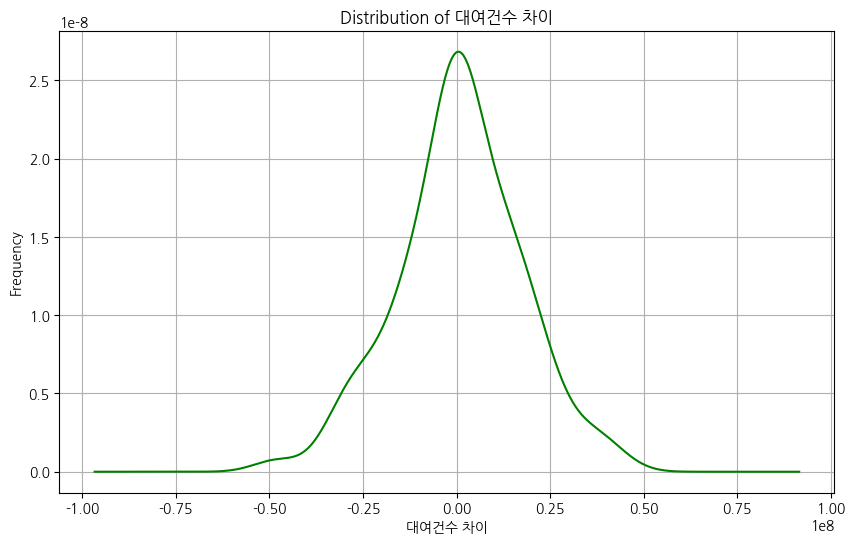

In [21]:
comparison_df = pd.merge(group_df_22, group_df_23, on=['month', 'day'], suffixes=('_22', '_23'))
comparison_df['대여건수_차이'] = comparison_df['대여건수_23'] - comparison_df['대여건수_22']

use_count_difference = comparison_df['대여건수_차이']

# Plot the histogram
plt.figure(figsize=(10, 6))
use_count_difference.plot(kind='kde', color='green')
plt.title('Distribution of 대여건수 차이')
plt.xlabel('대여건수 차이')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [22]:
comparison_df = pd.merge(group_df_22, group_df_23, on=['month', 'day'], suffixes=('_22', '_23'))
comparison_df['대여건수_차이'] = comparison_df['대여건수_23'] - comparison_df['대여건수_22']
comparison_df

,year_22,month,day,대여건수_22,year_23,대여건수_23,대여건수_차이
0,2022,7,1,34398225,2023,24117921,-10280304
1,2022,7,2,23299929,2023,23454649,154720
2,2022,7,3,17081689,2023,37773316,20691627
3,2022,7,4,28515600,2023,7123561,-21392039
4,2022,7,5,28408900,2023,38514436,10105536
...,...,...,...,...,...,...,...
179,2022,12,27,3833764,2023,7929856,4096092
180,2022,12,28,3407716,2023,7817616,4409900
181,2022,12,29,3988009,2023,8561476,4573467
182,2022,12,30,3396649,2023,273529,-3123120


In [23]:
group_7_8 = comparison_df[(comparison_df['month'] == 7) | (comparison_df['month'] == 8)]
group_9_10 = comparison_df[(comparison_df['month'] == 9) | (comparison_df['month'] == 10)]
group_11_12 = comparison_df[(comparison_df['month'] == 11) | (comparison_df['month'] == 12)]

In [24]:
#정규성 확인
shapiro_jul_aug = stats.shapiro(group_7_8['대여건수_차이'])
shapiro_sept_oct = stats.shapiro(group_9_10['대여건수_차이'])
shapiro_nov_dec = stats.shapiro(group_11_12['대여건수_차이'])
print(f'shapiro_jul_aug:{shapiro_jul_aug}')
print(f'shapiro_sept_oct:{shapiro_sept_oct}')
print(f'shapiro_nov_dec:{shapiro_nov_dec}')

shapiro_jul_aug:ShapiroResult(statistic=0.9846420890602211, pvalue=0.6304701481232631)
shapiro_sept_oct:ShapiroResult(statistic=0.9768512686758184, pvalue=0.3000327295439549)
shapiro_nov_dec:ShapiroResult(statistic=0.9535264941089006, pvalue=0.021281244077499057)


In [25]:
#Kruskal 방식 사용
kruskal_test_result = stats.kruskal(group_7_8['대여건수_차이'], group_9_10['대여건수_차이'], group_11_12['대여건수_차이'])
kruskal_test_result

KruskalResult(statistic=3.5321418295955027, pvalue=0.17100355815059343)